In [1]:
from halotools.sim_manager import CachedHaloCatalog, FakeSim
from halotools.empirical_models import PrebuiltHodModelFactory, Zheng07Cens, Zheng07Sats, TrivialPhaseSpace, NFWPhaseSpace, HodModelFactory
from halotools.mock_observables import return_xyz_formatted_array,wp
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time
from multiprocessing import Pool, cpu_count
import emcee
#import corner
#from Corrfunc.theory.wp import wp
import MCMC_data_file
from numpy.linalg import inv
import scipy.optimize as op
from scipy.stats import chi2
import scipy.stats as stats
import random
import warnings
warnings.filterwarnings("ignore")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from scipy.special import gamma
from scipy.stats import chisquare, gaussian_kde
from tabcorr import TabCorr
import numpy as np
from os import walk
import gc

In [10]:
fname = 'zehavi_smdpl_mvir_m21_tabcorr_2.h5'
wp_out_file = None#'zehavi_smdpl_mvir_m19_wp.npy'
dname ='zehavi_data_file_20'
param = 'combo'
threshold = -20

if '21' in dname:
    import zehavi_data_file_21
    print(dname)
    wp_ng_vals = zehavi_data_file_21.get_wp()[0:12]
    bin_edges = zehavi_data_file_21.get_bins()[0:12]
    cov_matrix = zehavi_data_file_21.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.

if '20' in dname:
    import zehavi_data_file_20
    wp_ng_vals = zehavi_data_file_20.get_wp()[0:12]
    bin_edges = zehavi_data_file_20.get_bins()[0:12]
    cov_matrix = zehavi_data_file_20.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.

if '19' in dname:
    import zehavi_data_file_19
    print(dname)
    wp_ng_vals = zehavi_data_file_19.get_wp()[0:12]
    bin_edges = zehavi_data_file_19.get_bins()[0:12]
    cov_matrix = zehavi_data_file_19.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.

In [4]:
halocat = CachedHaloCatalog(fname = '/Users/lmezini/.astropy/cache/halotools/halo_catalogs/SMDPL/rockstar/smdpl.dat.smdpl2.hdf5',update_cached_fname = True)
halocat.redshift=0.
ht = halocat.halo_table
vmax_ml = 10**(np.log10(ht['halo_vmax'])*3.1069839419403174+5.015822745222037)
ht.add_column(vmax_ml, name='vmax_ml')

pi_max = 60.
Lbox = 400.

hmvir = halocat.halo_table['halo_mvir']
hvmax = halocat.halo_table['vmax_ml']


class TabNames(object):
    def __init__(self, f):
        self.f = f
        self.a = float(f[:-5].split('combo_a')[1])
        self.model_instance = _get_model_inst(self.a)

def _get_model_inst(a):
    halocat.halo_table.add_column((hmvir**a)*(hvmax**(1-a)),name='combo')

    cens_occ_model = Zheng07Cens(prim_haloprop_key = 'combo',
                                 threshold=threshold)
    cens_prof_model = TrivialPhaseSpace()

    sats_occ_model =  Zheng07Sats(prim_haloprop_key = 'combo',
                                  modulate_with_cenocc=True,
                                  threshold=threshold)
    sats_prof_model = NFWPhaseSpace()

    model_instance = HodModelFactory(centrals_occupation = cens_occ_model,
                                     centrals_profile = cens_prof_model,
                                     satellites_occupation = sats_occ_model,
                                     satellites_profile = sats_prof_model)
    del(halocat.halo_table['combo'])
    return model_instance

def _get_wp_ng(model_instance,f):
    ngals,wp = TabCorr.read('/Users/lmezini/Halo/tabcorr_tables/{}'.format(f)).predict(model_instance)
    return ngals,wp

_, _, filenames = next(walk('/Users/lmezini/Halo/tabcorr_tables/'))
tab_names = [TabNames(f) for f in filenames]
mod_inst = [TabNames(f).model_instance for f in filenames]
tab_names_dict = dict(zip(filenames, tab_names))
mod_names_dict = dict(zip(filenames, mod_inst))

gc.collect()

0

In [5]:
def _get_wp_ng(model_instance,f):
    ngals,wp = TabCorr.read('/Users/lmezini/Halo/tabcorr_tables/{}'.format(f)).predict(model_instance)
    return ngals,wp

In [8]:
halocat = CachedHaloCatalog(fname = '/Users/lmezini/.astropy/cache/halotools/halo_catalogs/SMDPL/rockstar/smdpl.dat.smdpl2.hdf5',update_cached_fname = True)
halocat.redshift=0.
ht = halocat.halo_table
mvir = ht['halo_mvir']
c = ht['halo_nfw_conc']
hms = ht['halo_halfmass_scale']

bin_num = 71
bins=np.logspace(8,15.1,num=bin_num)
d = []
for i in range(1,bin_num):
    mask = np.logical_and(mvir>bins[i-1],mvir<bins[i])
    d.append((c[mask]-np.mean(c[mask]))/np.std(c[mask]))
i = bin_num
mask = np.where(mvir>bins[i-1])
d.append((c[mask]-np.mean(c[mask]))/np.std(c[mask]))
d = np.concatenate(d)
A = -0.66784885
halocat.halo_table.add_column(10**(np.log10(mvir)+(A*d)),name='combo')

pi_max = 60.
Lbox = 400.

cens_occ_model = Zheng07Cens(prim_haloprop_key = 'combo',
                                 threshold=threshold)
cens_prof_model = TrivialPhaseSpace()

sats_occ_model =  Zheng07Sats(prim_haloprop_key = 'combo',
                                  modulate_with_cenocc=True,
                                  threshold=threshold)
sats_prof_model = NFWPhaseSpace()

model_instance = HodModelFactory(centrals_occupation = cens_occ_model,
                                     centrals_profile = cens_prof_model,
                                     satellites_occupation = sats_occ_model,
                                     satellites_profile = sats_prof_model)
del(halocat.halo_table['combo'])

In [11]:
param_sampling =[.015,11.889, 0.053, 0.976, 12.505, 12.505]


[0.015, 11.889, 0.053, 0.976, 12.505, 12.505]


Text(0.5, 1.0, 'combo M<-20')

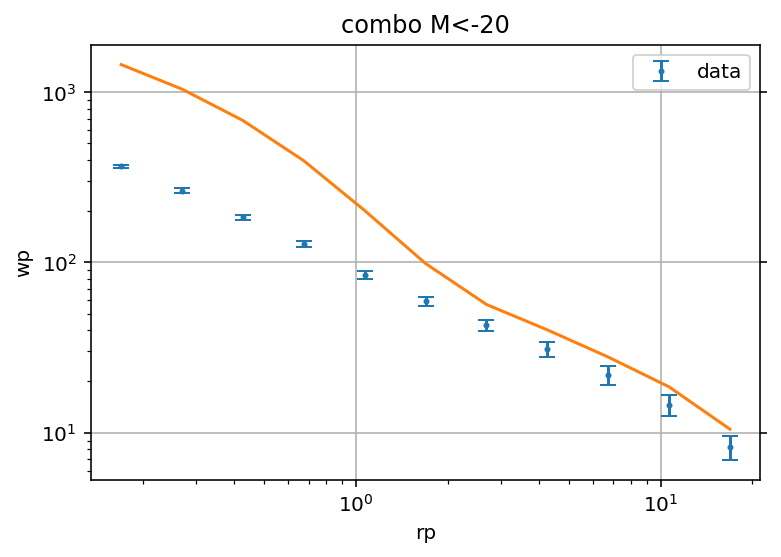

In [14]:
plt.errorbar(bin_cen,wp_ng_vals[1:len(wp_ng_vals)],yerr=np.sqrt(err),fmt='o',markersize=2,capsize=4,label='data')
for i in range(1):
    #a = i/100.
    a = param_sampling[0]
    #print(a)
    model_instance = mod_names_dict['smdpl_combo_a{}.hdf5'.format(round(a,2))]
        #cens_occ_model = Zheng07Cens(threshold=threshold)
        #cens_prof_model = TrivialPhaseSpace()

        #sats_occ_model =  Zheng07Sats(modulate_with_cenocc=True,threshold=threshold)
        #sats_prof_model = NFWPhaseSpace()

        #model_instance = HodModelFactory(centrals_occupation = cens_occ_model,
        #centrals_profile = cens_prof_model, satellites_occupation = sats_occ_model, 
        #satellites_profile = sats_prof_model)
    print(param_sampling)
    model_instance.param_dict['logMmin'] = param_sampling[1]#Mmin_val[i]
    model_instance.param_dict['sigma_logM'] = param_sampling[2]#sigma_val[i]
    model_instance.param_dict['alpha'] = param_sampling[3]#alpha_val[i]
    model_instance.param_dict['logM0'] = param_sampling[4]#M0_val[i]
    model_instance.param_dict['logM1'] = param_sampling[5]#M1_val[i]
    a = 1.0
    ngal,wp = _get_wp_ng(model_instance,'smdpl_combo_a{}.hdf5'.format(round(a,2)))
    plt.plot(bin_cen,wp,markersize=2)#,label='Vmax')
#plt.plot(bin_cen,oldfunc,label='Old Corrfunc')
#plt.title("")
plt.legend()
plt.ylabel('wp')
plt.xlabel('rp')
plt.tick_params(right=True)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.title(fname)
#plt.savefig('a_vs_wp.png')
plt.title("{} M<{}".format(param,threshold))
#plt.savefig('wp_plot_{}_m{}.pdf'.format(param,threshold))

In [8]:
a = 1.
model_instance = _get_model_inst(a)
a1_ngals, a1_wp = TabCorr.read('/Users/lmezini/Halo/tabcorr_tables/{}'.format('smdpl_combo_a1.0.hdf5')).predict(model_instance)

-21


In [17]:
a1_wp

array([862.73867897, 534.00670408, 321.96897692, 194.60689733,
       120.13808987,  77.49532516,  53.09797376,  38.84055631,
        26.97306332,  17.83261174,  10.23139115])

In [12]:
"""
del(ht['vmax_ml'])
ht = halocat.halo_table
vmax_ml = 10**(np.log10(ht['halo_vmax'])*3.1069839419403174+5.015822745222037)
ht.add_column(vmax_ml, name='vmax_ml')
cens_occ_model = Zheng07Cens(prim_haloprop_key = 'vmax_ml',threshold=threshold)
cens_prof_model = TrivialPhaseSpace()

sats_occ_model =  Zheng07Sats(prim_haloprop_key = 'vmax_ml', modulate_with_cenocc=True,threshold=threshold)
sats_prof_model = NFWPhaseSpace()

model_instance = HodModelFactory(centrals_occupation = cens_occ_model, centrals_profile = cens_prof_model, satellites_occupation = sats_occ_model, satellites_profile = sats_prof_model)
"""
cens_occ_model = Zheng07Cens(threshold=threshold)
cens_prof_model = TrivialPhaseSpace()

sats_occ_model =  Zheng07Sats(modulate_with_cenocc=True,threshold=threshold)
sats_prof_model = NFWPhaseSpace()

model_instance = HodModelFactory(centrals_occupation = cens_occ_model, centrals_profile = cens_prof_model, satellites_occupation = sats_occ_model, satellites_profile = sats_prof_model)

In [14]:
ngals, wp = TabCorr.read('smdpl_halo_mvir.hdf5').predict(model_instance)

In [16]:
wp

array([864.54091796, 533.78543688, 321.94574182, 194.73829736,
       120.09692911,  77.42466483,  53.10866712,  38.83533469,
        26.97674812,  17.83838629,  10.2306561 ])

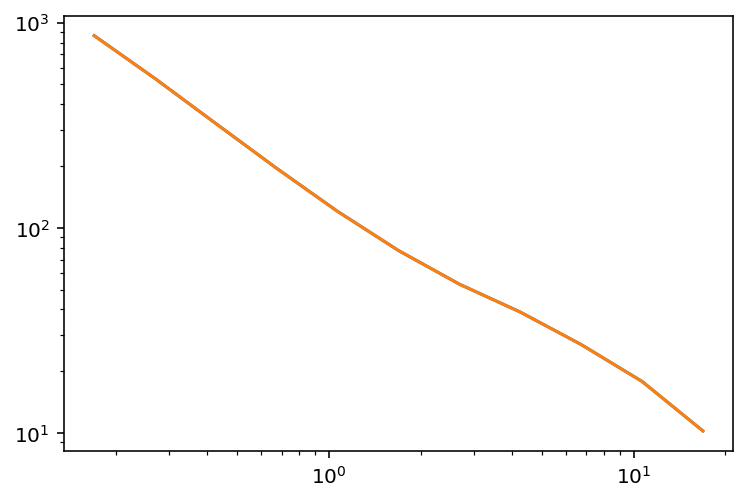

In [21]:
plt.loglog(bin_cen,wp)
plt.loglog(bin_cen,a1_wp)